# I. Data import and wrangling

## 1. Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

## 2. Importing data

In [ ]:
sns.set(rc={'figure.figsize':(15,5)})

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d carrie1/ecommerce-data
!unzip ecommerce-data.zip

Saving kaggle.json to kaggle.json
 69% 5.00M/7.20M [00:00<00:00, 52.0MB/s]
100% 7.20M/7.20M [00:00<00:00, 69.2MB/s]
Archive:  ecommerce-data.zip
  inflating: data.csv                


In [ ]:
df = pd.read_csv('data.csv', encoding='ISO-8859-1')

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
df.describe(include = 'object')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


# II. Data cleaning

In [ ]:
# Remove transactions with quantity <= 0
df = df[df['Quantity'] > 0]

In [ ]:
# Remove transactions that were cancelled
df = df[~df['InvoiceNo'].str.startswith('C')]

In [ ]:
# Remove null values
df.dropna(inplace = True)

In [ ]:
# Convert InvoiceDate and CustomerID to suitable format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df['CustomerID'] = df['CustomerID'].astype('int')

In [ ]:
# Create 'Value' column
df['Value'] = df['Quantity'] * df['UnitPrice']

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Value
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,20.34


# III. Exploratory Data Analysis

## 1. Top customers

In [ ]:
order_count = df.groupby('CustomerID').agg({'InvoiceNo':'nunique',
                                            'StockCode': 'nunique',
                                            'Quantity': 'sum',
                                            'Value': 'sum'}).reset_index()
order_count

,CustomerID,InvoiceNo,StockCode,Quantity,Value
0,12346,1,1,74215,77183.60
1,12347,7,103,2458,4310.00
2,12348,4,22,2341,1797.24
3,12349,1,73,631,1757.55
4,12350,1,17,197,334.40
...,...,...,...,...,...
4334,18280,1,10,45,180.60
4335,18281,1,7,54,80.82
4336,18282,2,12,103,178.05
4337,18283,16,263,1397,2094.88


Text(0, 0.5, 'Number of orders')

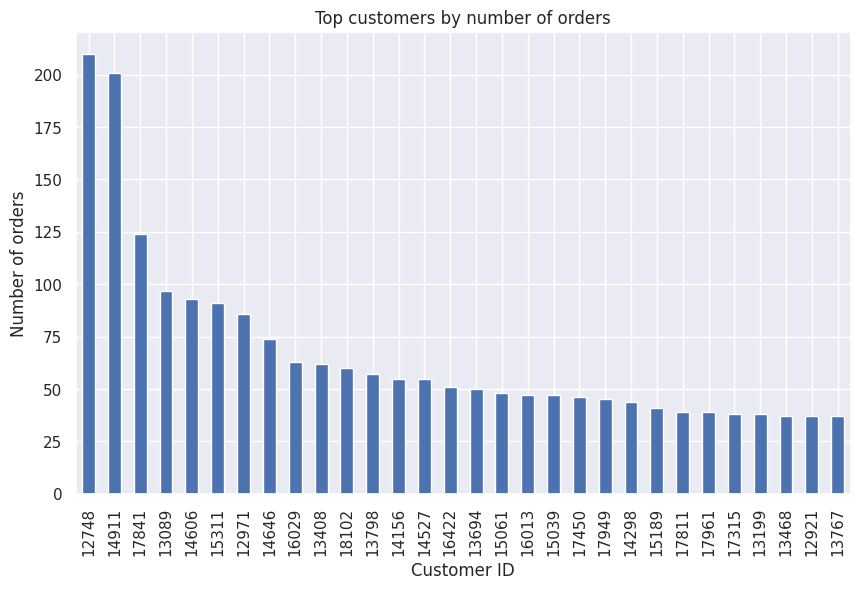

In [ ]:
top_orders = order_count.sort_values('InvoiceNo', ascending=False)[['CustomerID', 'InvoiceNo']].head(30).set_index('CustomerID')
top_orders.plot(kind='bar', legend=False)
plt.title('Top customers by number of orders')
plt.xlabel('Customer ID')
plt.ylabel('Number of orders')

Text(0, 0.5, 'Total of orders')

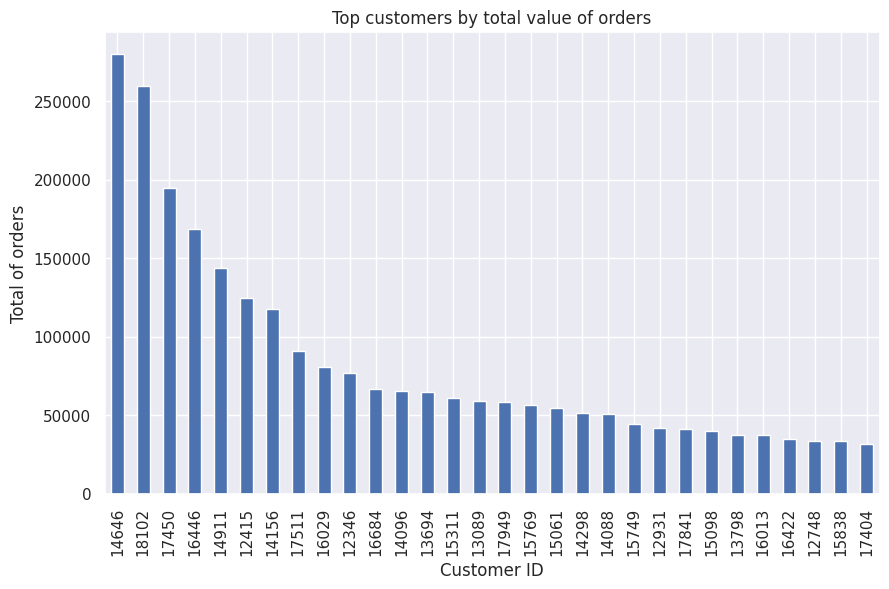

In [ ]:
top_orders = order_count.sort_values('Value', ascending=False)[['CustomerID', 'Value']].head(30).set_index('CustomerID')
top_orders.plot(kind='bar', legend=False)
plt.title('Top customers by total value of orders')
plt.xlabel('Customer ID')
plt.ylabel('Total of orders')

## 2. Top countries

In [ ]:
df['Country'].value_counts()

United Kingdom          354345
Germany                   9042
France                    8342
EIRE                      7238
Spain                     2485
Netherlands               2363
Belgium                   2031
Switzerland               1842
Portugal                  1462
Australia                 1185
Norway                    1072
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon                     45
Lithuani

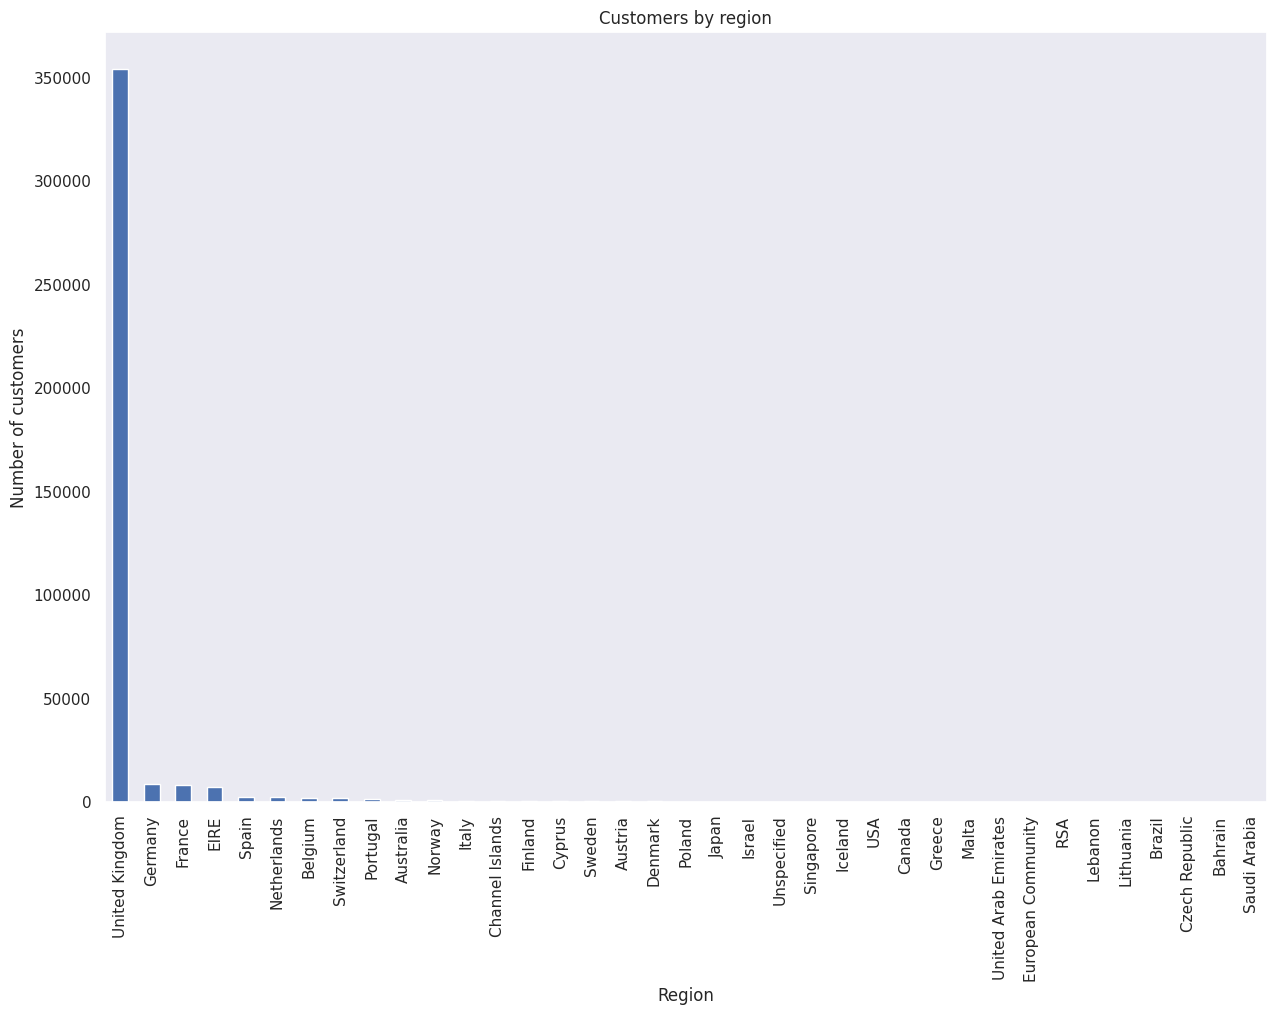

In [ ]:
df['Country'].value_counts().plot(kind='bar')
plt.title('Customers by region')
plt.xlabel('Region')
plt.ylabel('Number of customers')
plt.grid(False)

## IV. Cohort Analysis

In [ ]:
customer = df[['InvoiceNo','InvoiceDate','UnitPrice','CustomerID','Value']]
customer.head()

,InvoiceNo,InvoiceDate,UnitPrice,CustomerID,Value
0,536365,2010-12-01,2.55,17850,15.30
1,536365,2010-12-01,3.39,17850,20.34
2,536365,2010-12-01,2.75,17850,22.00
3,536365,2010-12-01,3.39,17850,20.34
4,536365,2010-12-01,3.39,17850,20.34


## 1. New customers each month

In [ ]:
# Create the truncated month of the purchase date
customer['OrderMonth'] = pd.to_datetime(df['InvoiceDate']).dt.to_period('M')

<ipython-input-31-2cbfe790eaba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer['OrderMonth'] = pd.to_datetime(df['InvoiceDate']).dt.to_period('M')


In [ ]:
# Create 'Cohort' based on the month of the first purchase date
customer['Cohort'] = customer.groupby('CustomerID')['OrderMonth'].transform('min')
customer.head()

<ipython-input-17-d5b43b20fcf0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer['Cohort'] = customer.groupby('CustomerID')['OrderMonth'].transform('min')


,InvoiceNo,InvoiceDate,UnitPrice,CustomerID,Value,OrderMonth,Cohort
0,536365,2010-12-01,2.55,17850,15.30,2010-12,2010-12
1,536365,2010-12-01,3.39,17850,20.34,2010-12,2010-12
2,536365,2010-12-01,2.75,17850,22.00,2010-12,2010-12
3,536365,2010-12-01,3.39,17850,20.34,2010-12,2010-12
4,536365,2010-12-01,3.39,17850,20.34,2010-12,2010-12


In [ ]:
# Aggregate the data per cohort and order_month and count the number of unique customers in each group
df_cohort = customer.groupby(['Cohort', 'OrderMonth']).agg(n_customers=('CustomerID', 'nunique')).reset_index(drop=False)
df_cohort.head()

,Cohort,OrderMonth,n_customers
0,2010-12,2010-12,885
1,2010-12,2011-01,324
2,2010-12,2011-02,286
3,2010-12,2011-03,340
4,2010-12,2011-04,321


In [ ]:
# Create a table to count number of new customers by cohort/month
new_cus = customer.groupby('Cohort')['CustomerID'].nunique()
new_cus = pd.DataFrame(new_cus)
new_cus.columns = ['CustomerCount']
new_cus = new_cus.reset_index()
new_cus['Cohort'] = new_cus['Cohort'].astype('str')
new_cus

,Cohort,CustomerCount
0,2010-12,885
1,2011-01,417
2,2011-02,380
3,2011-03,452
4,2011-04,300
5,2011-05,284
6,2011-06,242
7,2011-07,188
8,2011-08,169
9,2011-09,299


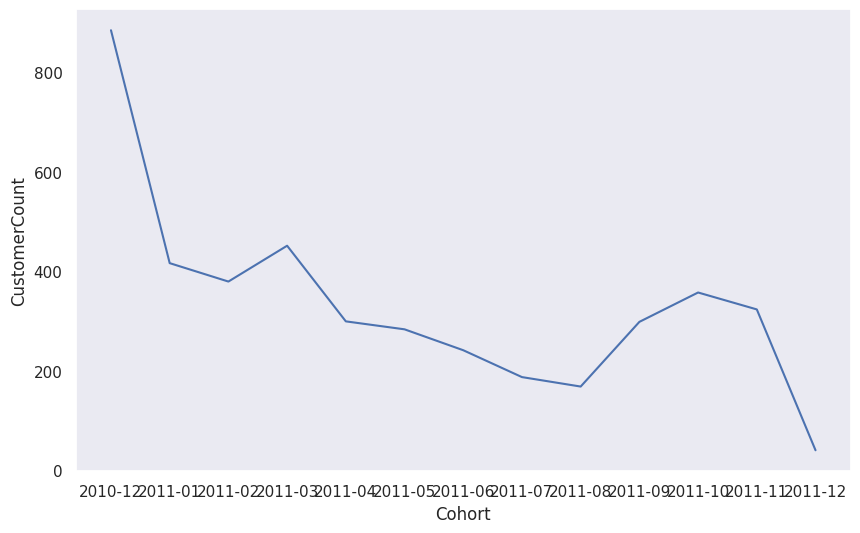

In [ ]:
sns.lineplot(data = new_cus, x = 'Cohort', y = 'CustomerCount')
plt.grid(False)

Overall, there was a decrease in the number of new customers joining the platform during the period. However there were two spikes in the figure, one in March and the other in October - November 2011.

## 2. Retention Analysis

In [ ]:
# Add period number based on OrderMonth
from operator import attrgetter
df_cohort['Period'] = (df_cohort.OrderMonth - df_cohort.Cohort).apply(attrgetter('n'))
df_cohort.head()

,Cohort,OrderMonth,n_customers,Period
0,2010-12,2010-12,885,0
1,2010-12,2011-01,324,1
2,2010-12,2011-02,286,2
3,2010-12,2011-03,340,3
4,2010-12,2011-04,321,4


In [ ]:
cohort_size = cohort_pivot.iloc[:, 0]
cohort_pivot = df_cohort.pivot_table(index='Cohort', columns='Period', values='n_customers')
cohort_pivot

Period,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Create retention matrix
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
retention_matrix

Period,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
2011-01,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,NaN
2011-02,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,NaN,NaN
2011-03,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
2011-04,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN
2011-05,1.0,0.190141,0.172535,0.172535,0.207746,0.232394,0.264085,0.095070,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.173554,0.157025,0.264463,0.231405,0.334711,0.095041,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.180851,0.207447,0.223404,0.271277,0.111702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.207101,0.248521,0.242604,0.124260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


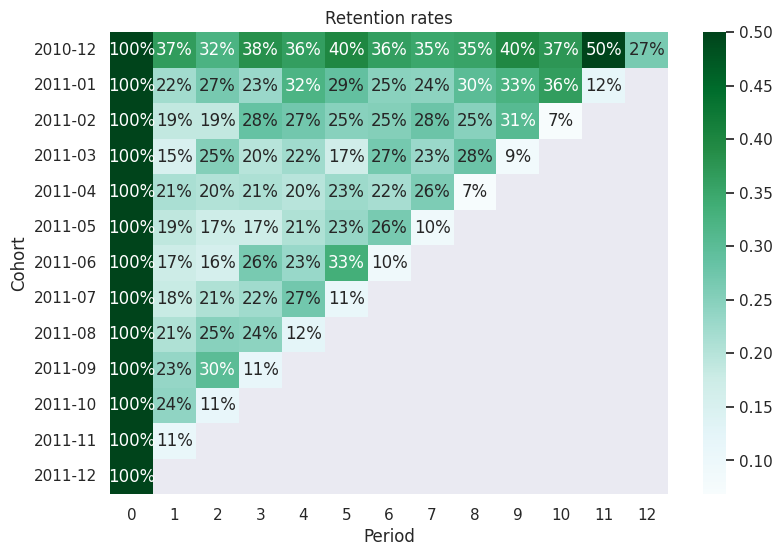

In [ ]:
plt.title('Retention rates')
sns.heatmap(data = retention_matrix,
            annot = True,
            fmt='.0%',
            vmax = 0.5,
            cmap = 'BuGn')
plt.grid(False)
plt.show()

Overall, it can be seen that the retention rate for all cohorts decreased dramatically in the second month, on average around 80% of customers did not make any purchase in the second month. However, the earlier cohorts (2010-12, 2011-01) seem to be doing better than the later cohorts. These might be a cohort of loyal customers who may have joined the platform since the beginning and established connection with the retailers.

# IV. K-Means Clustering

## 1. Generate RFM dataframe

The RFM analysis segments customers based on three metrics:
* Recency: Numbers of days from the last purchase
* Frequency: Numbers of purchase
* Monetary: Total amount spent




In [ ]:
# Create rfm table
rfm = df.groupby('CustomerID').agg({'InvoiceDate': 'max',
                                    'InvoiceNo': 'nunique',
                                    'Value': 'sum'}).reset_index()
rfm

,CustomerID,InvoiceDate,InvoiceNo,Value
0,12346,2011-01-18,1,77183.60
1,12347,2011-12-07,7,4310.00
2,12348,2011-09-25,4,1797.24
3,12349,2011-11-21,1,1757.55
4,12350,2011-02-02,1,334.40
...,...,...,...,...
4334,18280,2011-03-07,1,180.60
4335,18281,2011-06-12,1,80.82
4336,18282,2011-12-02,2,178.05
4337,18283,2011-12-06,16,2094.88


In [ ]:
rfm.columns = ['customer_id', 'last_order_date', 'frequency', 'monetary']

In [ ]:
df['InvoiceDate'].max()

datetime.date(2011, 12, 9)

In [ ]:
# Create recency column by subtracting the last purchase date in the whole dataset by each customer last order date
rfm['recency'] = [(dt.date(2011,12,9) - x).days for x in rfm['last_order_date']]

In [ ]:
# Filter out unrelated columns
rfm = rfm[['customer_id', 'recency', 'frequency', 'monetary']]
rfm.head()

,customer_id,recency,frequency,monetary
0,12346,325,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,18,1,1757.55
4,12350,310,1,334.40


<ipython-input-18-aa800ad4a925>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['recency'])


Text(0.5, 0, 'Number of orders')

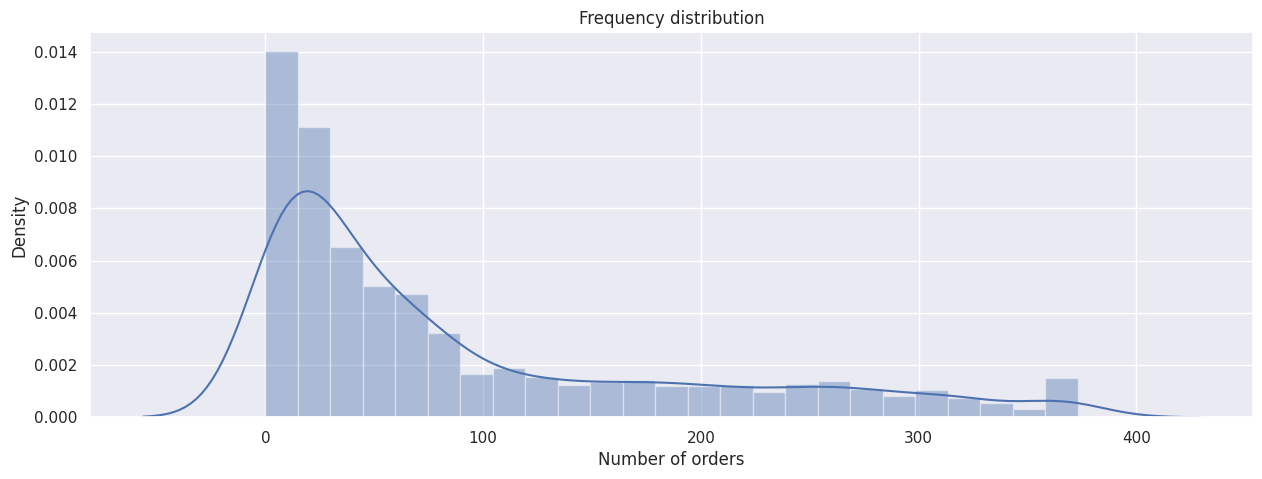

In [ ]:
# Visualize recency distribution
sns.distplot(rfm['recency'])
plt.title('Frequency distribution')
plt.xlabel('Number of orders')

<ipython-input-45-baa08f98d233>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['frequency'])


Text(0.5, 0, 'Number of orders')

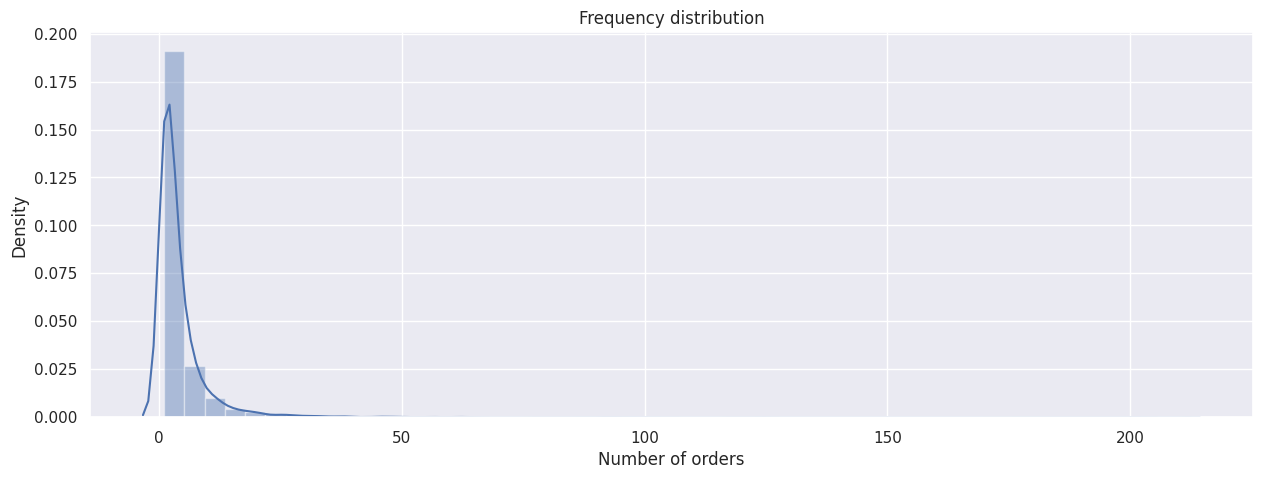

In [ ]:
# Visualize frequency distribution
sns.distplot(rfm['frequency'])
plt.title('Frequency distribution')
plt.xlabel('Number of orders')

<ipython-input-46-c2fa6ce26326>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['monetary'])


Text(0.5, 0, 'Total amount spent')

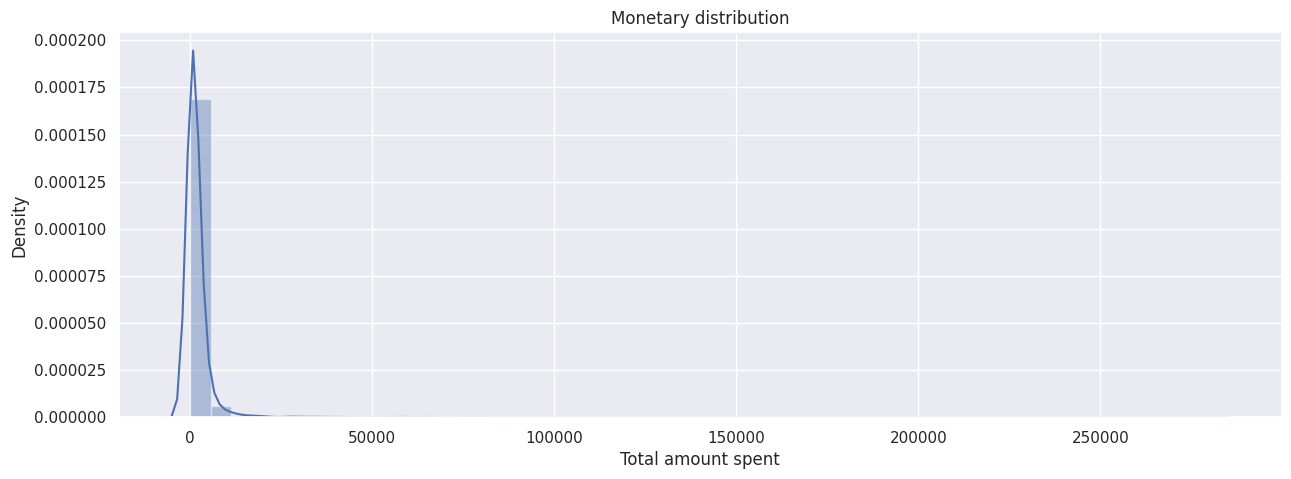

In [ ]:
# Visualize monetary distribution
sns.distplot(rfm['monetary'])
plt.title('Monetary distribution')
plt.xlabel('Total amount spent')

In [ ]:
# Compute the quantiles
quantiles = rfm[["frequency","recency","monetary"]].quantile([0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99])
quantiles

# Remove 5% outliers
rfm = rfm[(rfm['recency'] <= quantiles.loc[0.95, 'recency']) &
          (rfm['frequency'] <= quantiles.loc[0.95, 'frequency']) &
          (rfm['monetary'] <= quantiles.loc[0.95, 'monetary'])]

## 2. Process data and calculate numbers of clusters for K-Means

In [ ]:
# Scale datapoints down into a fixed range
train = rfm[['recency', 'frequency', 'monetary']]
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)

In [ ]:
train_scaled

array([[0.00643087, 0.5       , 0.74866812],
       [0.24115756, 0.25      , 0.31218939],
       [0.05787781, 0.        , 0.30529505],
       ...,
       [0.57877814, 0.        , 0.01403883],
       [0.02250804, 0.08333333, 0.03092816],
       [0.13504823, 0.16666667, 0.31914454]])

In [ ]:
# Calculate the optimal number of clusters using the elbow method
wssd = [] # within-cluster sum-of-squared-distances
silhouette = []
KS = list(range(2,11))
for k in KS:
  # train a KMeans model on the scaled training set
  model = KMeans(n_clusters = k).fit(train_scaled)
  # Calculate wssd
  wssd.append(model.inertia_/len(train))
  # Calculate silhouette
  cluster_labels = model.predict(train_scaled)
  silhouette.append(silhouette_score(train_scaled, cluster_labels))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [ ]:
wssd

[0.08883721808664209,
 0.04581252540487872,
 0.03620746080649788,
 0.029902935923329422,
 0.02589543045046536,
 0.022754278612755873,
 0.020438421206831633,
 0.01863636932288195,
 0.01730081497025795]

In [ ]:
silhouette

[0.451213351366845,
 0.49526374761824293,
 0.4210952595246016,
 0.39688304217960724,
 0.3879120198595884,
 0.37277196662445566,
 0.33816848495595747,
 0.34162863449877245,
 0.33056977593353415]

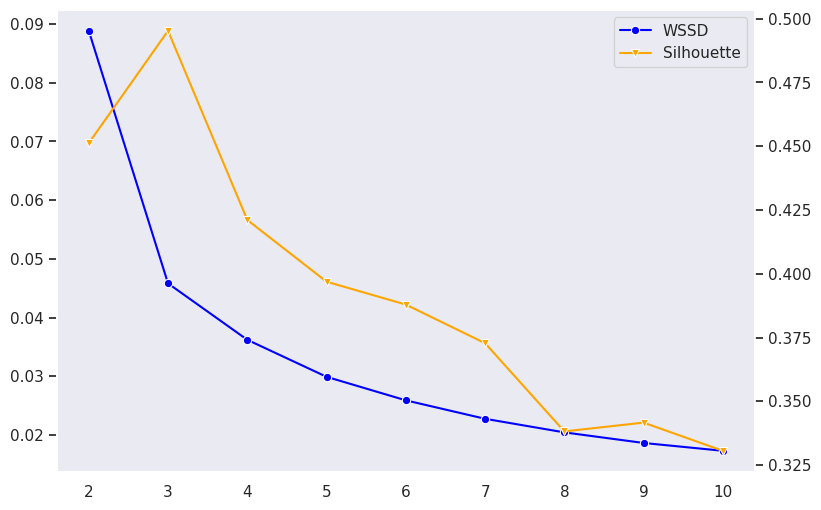

In [ ]:
# Visualize wwsd and silhouette score
plt.figure(figsize=(9, 6))
ax1 = sns.lineplot(
    x=KS, y=wssd, color='blue',
    marker='o',
    label='WSSD', legend=None
)
ax2 = ax1.twinx()
sns.lineplot(
    x=KS, y=silhouette, ax=ax2, color='orange',
    marker='v',
    label='Silhouette', legend=None
)

# Remove the grid
ax1.grid(False)
ax2.grid(False)

# Merge the legend
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=0)

The 'elbow' of the WSSD curve is at 3, and silhouette score is also the highest at 3 clusters. We will pick 3 as the number of clusters for our K-Means model

## 3. Final model

In [ ]:
model = KMeans(n_clusters = 3).fit(train_scaled)
cluster_labels = model.predict(train_scaled)
rfm['cluster'] = cluster_labels
rfm.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,customer_id,recency,frequency,monetary,cluster
1,12347,2,7,4310.00,1
2,12348,75,4,1797.24,0
3,12349,18,1,1757.55,0
4,12350,310,1,334.40,2
5,12352,36,8,2506.04,1


## 4. Cluster analysis

In [ ]:
# Cluster averages
cluster_avg = rfm.groupby('cluster').agg({'recency':'mean',
                                          'frequency':'mean',
                                          'monetary':'mean'})
cluster_avg

,recency,frequency,monetary
cluster,,,
0,46.021228,2.346101,708.357772
1,29.179283,7.289509,2758.987463
2,216.393013,1.589520,469.976191


In [ ]:
# Visualize the clusters using 3D graph
import plotly.express as px

fig = px.scatter_3d(rfm, x='recency', y='frequency', z='monetary',
              color='cluster')
fig.show()

Cụm đỏ: monetary relatively high, low recency, high frequency > Loyal, prevent churn
Blue: low frequency and recency > new customers, stronger marketing strategy and initiatives
Yellow: High recency, low frequency > churned

In [ ]:
rfm_scaled = rfm.copy()
rfm_scaled[['recency', 'frequency', 'monetary']] = train_scaled

In [ ]:
# Reformat the table into a long table
rfm_melted = pd.melt(rfm_scaled.reset_index(),
                     id_vars = ['customer_id', 'cluster'],
                     value_vars = ['recency', 'frequency', 'monetary'],
                     var_name = 'attribute',
                     value_name = 'value')
rfm_melted

,customer_id,cluster,attribute,value
0,12347,1,recency,0.006431
1,12348,0,recency,0.241158
2,12349,0,recency,0.057878
3,12350,2,recency,0.996785
4,12352,1,recency,0.115756
...,...,...,...,...
11503,18278,0,monetary,0.030207
11504,18280,2,monetary,0.031371
11505,18281,2,monetary,0.014039
11506,18282,0,monetary,0.030928


Text(0.5, 1.0, 'Cluster Snake Plot')

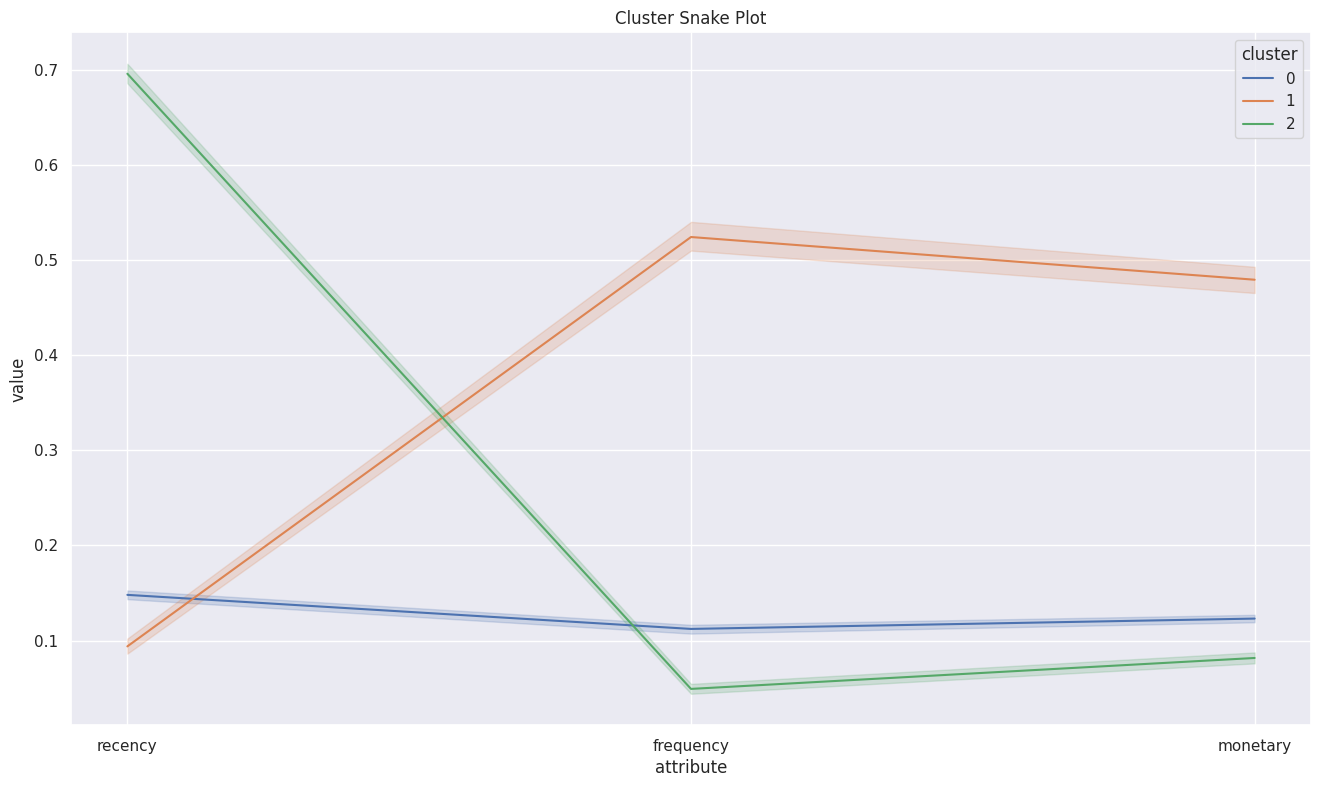

In [ ]:
# Visualize the clusters using a snake plot
plt.figure(figsize=(16,9))
sns.lineplot(data=rfm_melted, x='attribute', y='value', hue='cluster', palette='deep')
plt.title('Cluster Snake Plot')

The above plots visuzlize how K-Means clusters the data into 3 clusters:
* Cluster 0: New customers with low purchase frequency and value.
* Cluster 1: Loyal customers. Users in this segment are likely to make multiple purchases in a single order and are highly responsive to cross-selling and up-selling.
* Cluster 2: Churned customers

Cluster 0 and Cluster 1 are two important segments for the business. The business should come up with suitable promotion and rewards campaigns to encourage these customers and prevent them from churning.

In [ ]:
# Cluster descriptions
rfm.groupby('cluster').agg({'cluster':'count',
                            'recency':['min',np.median,'mean','max'],
                            'frequency':['min',np.median,'mean','max'],
                            'monetary':['min',np.median,'mean','max']})

cluster recency                         frequency                   \
          count     min median        mean  max       min median      mean   
cluster                                                                      
0           753       0   17.0   29.179283  264         1    7.0  7.289509   
1          2167       0   38.0   46.021228  140         1    2.0  2.346101   
2           916     127  213.0  216.393013  311         1    1.0  1.589520   

            monetary                                  
        max      min    median         mean      max  
cluster                                               
0        13   694.40  2578.090  2758.987463  5756.89  
1         7     0.00   593.750   708.357772  4008.62  
2         7     3.75   322.195   469.976191  4959.10